# Utilization Prediction: Prediction of hourly utilization of the two sites

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras import Sequential
from keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Load and prepare data

In [2]:
# Load data
charging_data = pd.read_pickle("data/charging_modified.pkl")

# Drop not important columns in charging data
charging_data.drop(columns = ["kWhDelivered", "NoChargingTime", "user_modifiedAt", "NoChargingTimeMinutes", "userRegistered", 
                              "spaceID", "stationID", "ChargingTime", "user_paymentRequired_values", "user_requestedDeparture", "userID", "ChargingTimeMinutes",
                              "user_kWhRequestFulfilment", "user_kWhRequested", "user_milesRequested", "user_minutesAvailable", "month", "weekday"], inplace = True)

# Delete rows with null values
charging_data = charging_data.dropna()

# Delete duplicate row index
charging_data.reset_index(drop = True, inplace = True)

charging_data = charging_data.astype({
    "siteID": "int64"
})

charging_data  = charging_data[:31670]
charging_data.reset_index(drop = True, inplace = True)
charging_data

,id,connectionTime,disconnectTime,doneChargingTime,siteID,NoChargingTimeHours,ChargingTimeHours,kWhPerMinute,user_WhPerMile
0,5bc915caf9af8b0dad3c0660,2018-04-30 15:07:49+00:00,2018-05-01 00:27:55+00:00,2018-05-01 00:27:51+00:00,2,0.001111,9.333889,0.085366,350.0
1,5bc917d0f9af8b0dc677b8bb,2018-05-07 14:38:18+00:00,2018-05-08 01:15:01+00:00,2018-05-08 01:14:53+00:00,2,0.002222,10.609722,0.043487,400.0
2,5bc9190ff9af8b0dc677b9c1,2018-05-11 15:17:01+00:00,2018-05-12 00:18:43+00:00,2018-05-11 23:05:56+00:00,2,1.213056,7.815278,0.037288,350.0
3,5bc919c3f9af8b0dc677ba32,2018-05-14 13:50:26+00:00,2018-05-14 23:09:45+00:00,2018-05-14 20:43:40+00:00,2,2.434722,6.887222,0.028543,400.0
4,5bc919c3f9af8b0dc677ba62,2018-05-15 00:06:39+00:00,2018-05-15 01:13:58+00:00,2018-05-15 00:39:01+00:00,2,0.582500,0.539444,0.095036,250.0
...,...,...,...,...,...,...,...,...,...
31665,5e5f049bf9af8b1299741150,2020-02-16 21:25:54+00:00,2020-02-16 23:12:58+00:00,2020-02-16 23:12:49+00:00,2,0.002500,1.781944,0.104801,250.0
31666,5e5f049bf9af8b1299741151,2020-02-16 21:29:00+00:00,2020-02-16 23:11:32+00:00,2020-02-16 23:11:27+00:00,2,0.001389,1.707500,0.055110,400.0
31667,5e5f049bf9af8b1299741153,2020-02-16 23:29:22+00:00,2020-02-17 00:43:55+00:00,2020-02-17 00:43:46+00:00,2,0.002500,1.240000,0.052742,400.0
31668,5e605626f9af8b166c709145,2020-02-17 17:00:27+00:00,2020-02-17 21:05:57+00:00,2020-02-17 19:19:18+00:00,1,1.777500,2.314167,0.097004,231.0


## Create feature vector X and labels Y

In [3]:
# Split time interval between connectionTime and doneChargingTime in minutes for every hour
def split_time_interval(index, start_date, end_date):
    indices = pd.DatetimeIndex([start_date])
    indices = indices.append(pd.date_range(start_date.ceil(freq = "H"), end_date.floor(freq = "H"), freq = "H"))
    indices = indices.append(pd.DatetimeIndex([end_date]))

    time_list = list(map(lambda x : 60 if x == 0 else x, indices.minute))
    time_list[0] = 60 - time_list[0]
    
    return list((time_list, indices))


# Create table with session id, charging time in minutes per hour, timestamps and siteID
def create_minute_table(id, minute_array, siteID):
    return list(zip([id] * len(minute_array[0]), minute_array[0], minute_array[1], [siteID] * len(minute_array[0])))

# Group entries by timestamp
def group_by_timestamp(X):
    X = X.groupby("timestamp").agg({ "siteID": "mean", "kWhDemandPerHour": "sum"})
    return X

In [4]:
# Concat single minute lists to one big list with lists of tuples containing id, charging times in minutes per, timestamps and siteID
temp = []

for index in charging_data.index :
    charging_times = split_time_interval(charging_data.index[index], 
                                         charging_data.loc[index, "connectionTime"], 
                                         charging_data.loc[index, "doneChargingTime"])
    temp.append(create_minute_table(charging_data.loc[index, "id"], charging_times, charging_data.loc[index, "siteID"]))
    
charging_data.drop("siteID", inplace = True, axis = 1)

# Parse list of lists into four lists: ids, charging time in minutes per hour, timestamps and siteIDs
ids, charging_times, timestamps, siteIDs = map(list, zip(*[tuple for list in temp for tuple in list]))

# Create data.frame with four columns: session id, charging time, starting timestamp in minutes for every hour and siteID
charging_time_per_hour = pd.DataFrame(
                            {"id": ids,
                             "charging_time_per_hour": charging_times,
                             "timestamp": timestamps,
                             "siteID": siteIDs})

charging_time_per_hour.loc[:, "timestamp"] = charging_time_per_hour.loc[:, "timestamp"].dt.floor(freq = "H")

### Labels Y:

In [5]:
# Join charge time per hour with the rest of the charging data
temp = charging_time_per_hour.merge(charging_data, how = "left", on = "id").drop(["connectionTime", "disconnectTime", "id"], axis = 1)

# Create column for delivered kWh per hour interval
temp["kWhDemandPerHour"] = temp["charging_time_per_hour"] * temp["kWhPerMinute"]

# Divide data set into two sets: one for each site
temp1 = temp.loc[temp["siteID"] == 1]
temp2 = temp.loc[temp["siteID"] == 2]

# Group entries by timestamp
temp1 = group_by_timestamp(temp1)
temp2 = group_by_timestamp(temp2)

# Combine the sets together into one
temp = pd.concat([temp1, temp2], axis = 0)

temp["timestamp"] = temp.index
temp.reset_index(drop = True, inplace = True)

In [6]:
# Define labels Y
Y = temp[["kWhDemandPerHour", "timestamp", "siteID"]]
Y

,kWhDemandPerHour,timestamp,siteID
0,1.350151,2018-10-08 13:00:00+00:00,1.0
1,14.708255,2018-10-08 14:00:00+00:00,1.0
2,26.380610,2018-10-08 15:00:00+00:00,1.0
3,26.380610,2018-10-08 16:00:00+00:00,1.0
4,26.380610,2018-10-08 17:00:00+00:00,1.0
...,...,...,...
16407,4.591399,2020-02-16 19:00:00+00:00,2.0
16408,5.376448,2020-02-16 21:00:00+00:00,2.0
16409,9.594663,2020-02-16 22:00:00+00:00,2.0
16410,13.093486,2020-02-16 23:00:00+00:00,2.0


### Feature Vector X:

In [7]:
X = temp.drop(["kWhDemandPerHour"],  axis = 1)

# Add weekday, month and hour as categorical variable
X["weekday"] = X["timestamp"].dt.day_name()
X["month"] = X["timestamp"].dt.month_name()
X["hour"] = X["timestamp"].dt.hour

X = X.fillna(0)

# Create dummies for categorical variables
X = X.astype({
    "siteID": "int64"
})
X = pd.get_dummies(X, columns = ["siteID", "weekday", "month", "hour"])

# Sort values after siteID and timestamp in ascending order
X.sort_values(["siteID_2", "timestamp"])
X

,timestamp,siteID_1,siteID_2,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2018-10-08 13:00:00+00:00,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2018-10-08 14:00:00+00:00,True,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,2018-10-08 15:00:00+00:00,True,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,2018-10-08 16:00:00+00:00,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,2018-10-08 17:00:00+00:00,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16407,2020-02-16 19:00:00+00:00,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
16408,2020-02-16 21:00:00+00:00,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
16409,2020-02-16 22:00:00+00:00,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
16410,2020-02-16 23:00:00+00:00,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True


## Cross-validation: split data in training and test set

In [8]:
# Split data into training set and testing set and normalize
scaler = StandardScaler()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.3, random_state = 30)

X_train_scaled = scaler.fit_transform(X_train.drop("timestamp", axis = 1))
X_test_scaled = scaler.transform(X_test.drop("timestamp", axis = 1))

# Create X sets for testing performance for each site
X_test_site1 = X_test[X_test["siteID_1"] == True].sort_values(["timestamp"])
X_test_site2 = X_test[X_test["siteID_2"] == True].sort_values(["timestamp"])

# Create Y sets for testing performance for each site
Y_test_site1 = Y_test[Y_test["siteID"] == 1.0].sort_values("timestamp").drop("timestamp", axis = 1).loc[:, "kWhDemandPerHour"]
Y_test_site2 = Y_test[Y_test["siteID"] == 2.0].sort_values("timestamp").drop("timestamp", axis = 1).loc[:, "kWhDemandPerHour"]

# Extract kWhDemandPerHour as labels
Y_train = Y_train.loc[:, "kWhDemandPerHour"]
Y_test = Y_test.loc[:, "kWhDemandPerHour"]

## Prediction model 1: Neural Network

In [9]:
# Build the neural network
network = Sequential()

# Add layers
network.add(Dense(input_shape = (45,), units = 21, activation = "relu"))
network.add(Dense(units = 21, activation = "relu"))
network.add(Dense(units = 1, activation = "relu"))

In [10]:
# Compile the neural network
network.compile(optimizer = "adam", 
                   loss = "mean_squared_error", 
                   metrics = ["mean_squared_error"])
network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ dense (Dense)                      │ (None, 21)                    │         966 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 21)                    │         462 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_2 (Dense)                    │ (None, 1)                     │          22 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 1,450 (5.66 KB)

 Trainable params: 1,450 (5.66 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Fit the Neural Network
network.fit(X_train_scaled, Y_train, batch_size=50, epochs=200)

Epoch 1/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3635.3110 - mean_squared_error: 3635.3340
Epoch 2/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1879.3882 - mean_squared_error: 1879.3605
Epoch 3/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1328.6625 - mean_squared_error: 1328.6675
Epoch 4/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1343.7803 - mean_squared_error: 1343.7883
Epoch 5/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1203.3145 - mean_squared_error: 1203.3221
Epoch 6/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1033.4979 - mean_squared_error: 1033.5010
Epoch 7/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 904.1271 - mean_squared_error: 904.1309
Epoch 8/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 970.2802 - mean_squared_error: 970.2834
Epoch 9/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 918.5795 - mean_squared_error: 918.5820
Epoch 10/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 835.1948 - mean_s

### Performance evaluation

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

# Evaluate performance
mse_nn  = mean_squared_error(Y_test, network.predict(X_test_scaled))
mae_nn  = mean_absolute_error(Y_test, network.predict(X_test_scaled))
msle_nn = mean_squared_log_error(Y_test, network.predict(X_test_scaled))
print("Mean squared error: " + str(mse_nn))
print("Mean absolute error: " + str(mae_nn))
print("Mean squared log error: " + str(msle_nn))

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean squared error: 489.14749658959244
Mean absolute error: 13.244941695027554
Mean squared log error: 1.9927670058264517


### Performance Visualization

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


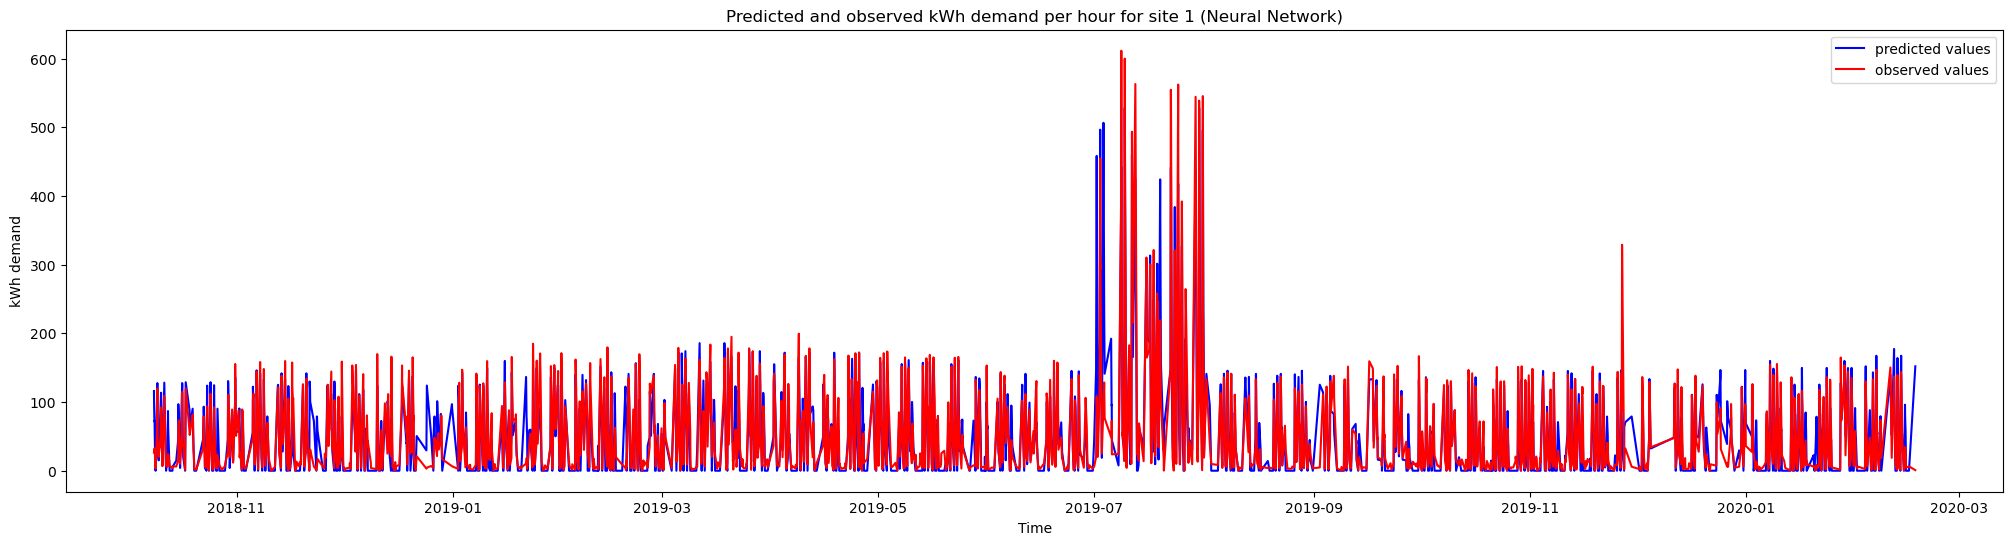

In [13]:
predictions_site1 = network.predict(scaler.transform(X_test_site1.drop("timestamp", axis = 1)))[:, 0]
timestamps = X_test_site1["timestamp"].sort_values()

# Visualization of the predicted value and the observed value over time for site 1
plt.figure(figsize = (25,6))

plt.plot(timestamps, predictions_site1, c = "blue", label = "predicted values")
plt.plot(timestamps, Y_test_site1, c = "red", label = "observed values")

plt.xlabel("Time")
plt.ylabel("kWh demand")
plt.title("Predicted and observed kWh demand per hour for site 1 (Neural Network)")
plt.legend()

plt.show()

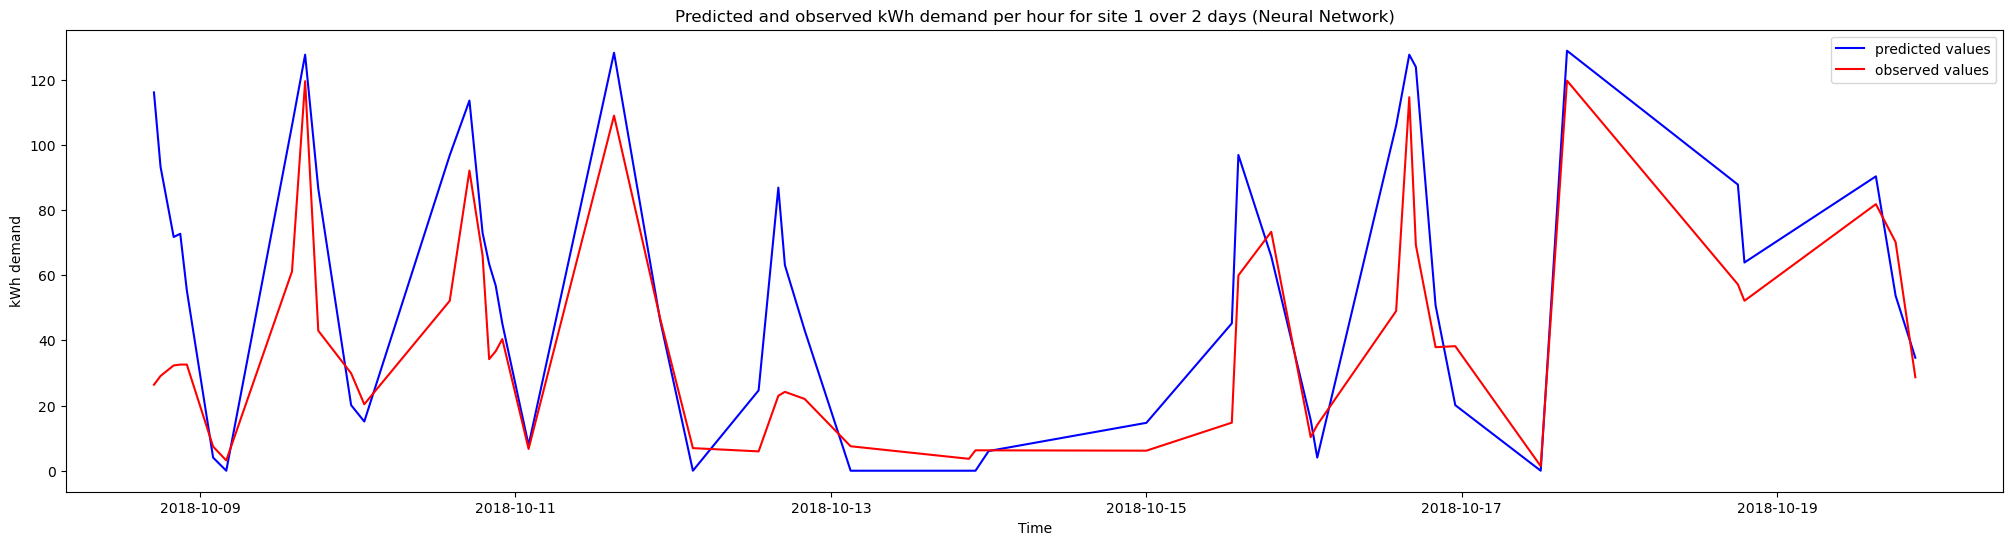

In [14]:
# Visualization of the predicted value and the observed value over 48 hours for site 1 (to visualize it better)
plt.figure(figsize = (25,6))

plt.plot(timestamps.iloc[0:48], predictions_site1[0:48], c = "blue", label = "predicted values")
plt.plot(timestamps.iloc[0:48], Y_test_site1[0:48], c = "red", label = "observed values")

plt.xlabel("Time")
plt.ylabel("kWh demand")
plt.title("Predicted and observed kWh demand per hour for site 1 over 2 days (Neural Network)")
plt.legend()

plt.show()

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


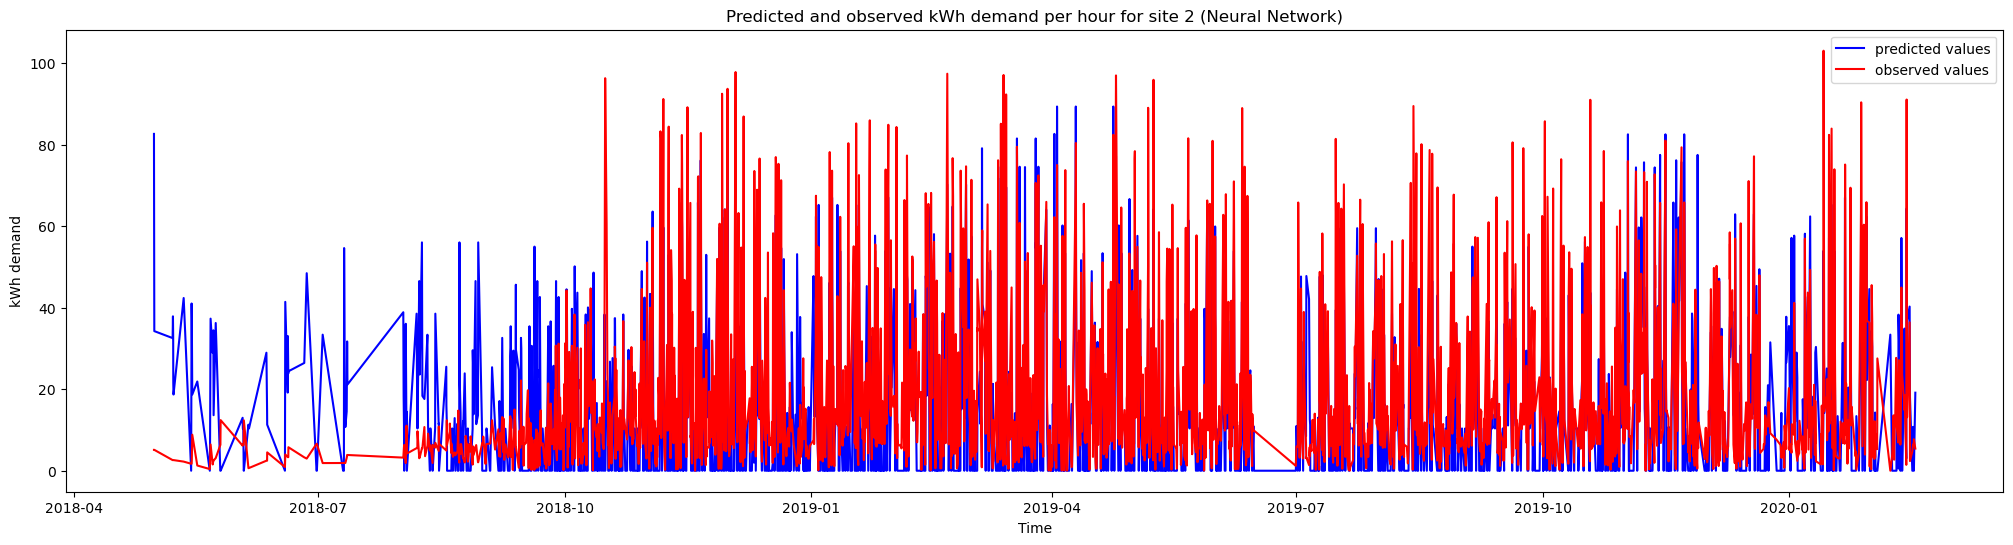

In [15]:
predictions_site2 = network.predict(scaler.transform(X_test_site2.drop("timestamp", axis = 1)))[:, 0]
timestamps = X_test_site2["timestamp"].sort_values()

# Visualization of the predicted value and the observed value over time for site 2
plt.figure(figsize = (25,6))

plt.plot(timestamps, predictions_site2, c = "blue", label = "predicted values")
plt.plot(timestamps, Y_test_site2, c = "red", label = "observed values")

plt.xlabel("Time")
plt.ylabel("kWh demand")
plt.title("Predicted and observed kWh demand per hour for site 2 (Neural Network)")
plt.legend()

plt.show()

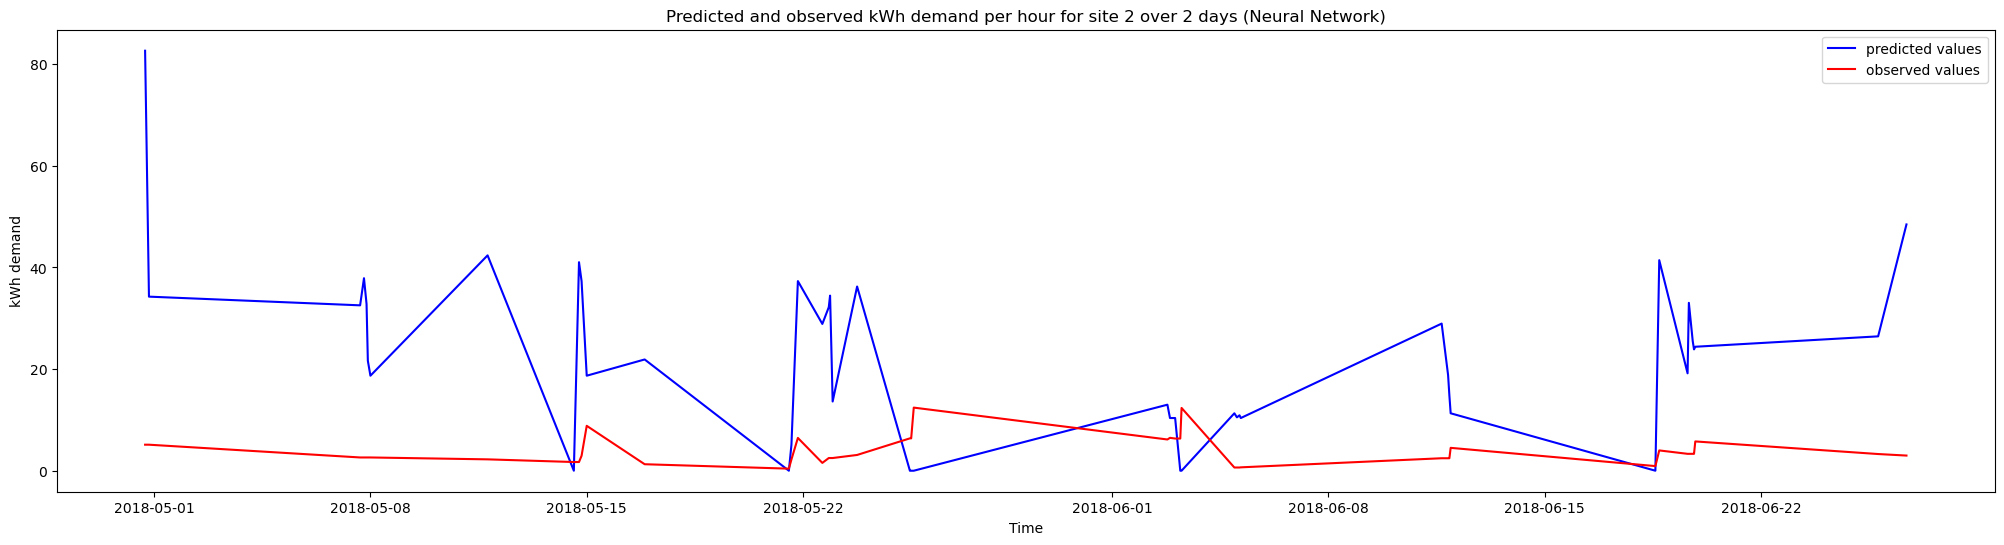

In [16]:
# Visualization of the predicted value and the observed value over 48 hours for site 2 (to visualize it better)
plt.figure(figsize = (25,6))

plt.plot(timestamps.iloc[0:48], predictions_site2[0:48], c = "blue", label = "predicted values")
plt.plot(timestamps.iloc[0:48], Y_test_site2[0:48], c = "red", label = "observed values")

plt.xlabel("Time")
plt.ylabel("kWh demand")
plt.title("Predicted and observed kWh demand per hour for site 2 over 2 days (Neural Network)")
plt.legend()

plt.show()

## Prediction Model 2: Decision Tree

In [41]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

# fit decision tree for regression
reg_tree = DecisionTreeRegressor(max_depth = 15, criterion = "squared_error")
reg_tree.fit(X_train_scaled, Y_train)

DecisionTreeRegressor(max_depth=15)

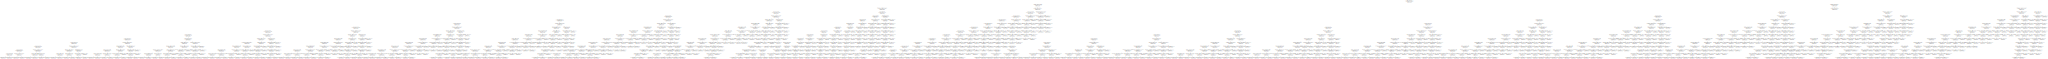

In [42]:
# Plot tree
data = export_graphviz(reg_tree, feature_names = X.drop("timestamp", axis = 1).columns)
graph = graphviz.Source(data)

graph

### Performance Evaluation

In [43]:
# Evaluate performance
mse_dt    = mean_squared_error(Y_test, reg_tree.predict(X_test_scaled))
mae_dt    = mean_absolute_error(Y_test, reg_tree.predict(X_test_scaled))
r2_dt     = r2_score(Y_test, reg_tree.predict(X_test_scaled))
print("Mean squared error: " + str(mse_dt))
print("Mean absolute rror: " + str(mae_dt))
print("R2 score: " + str(r2_dt))

print(np.mean(Y_test))

Mean squared error: 702.2180493153523
Mean absolute rror: 13.80451243765575
R2 score: 0.7389873533857543
35.02164959776053


### Performance Visualization

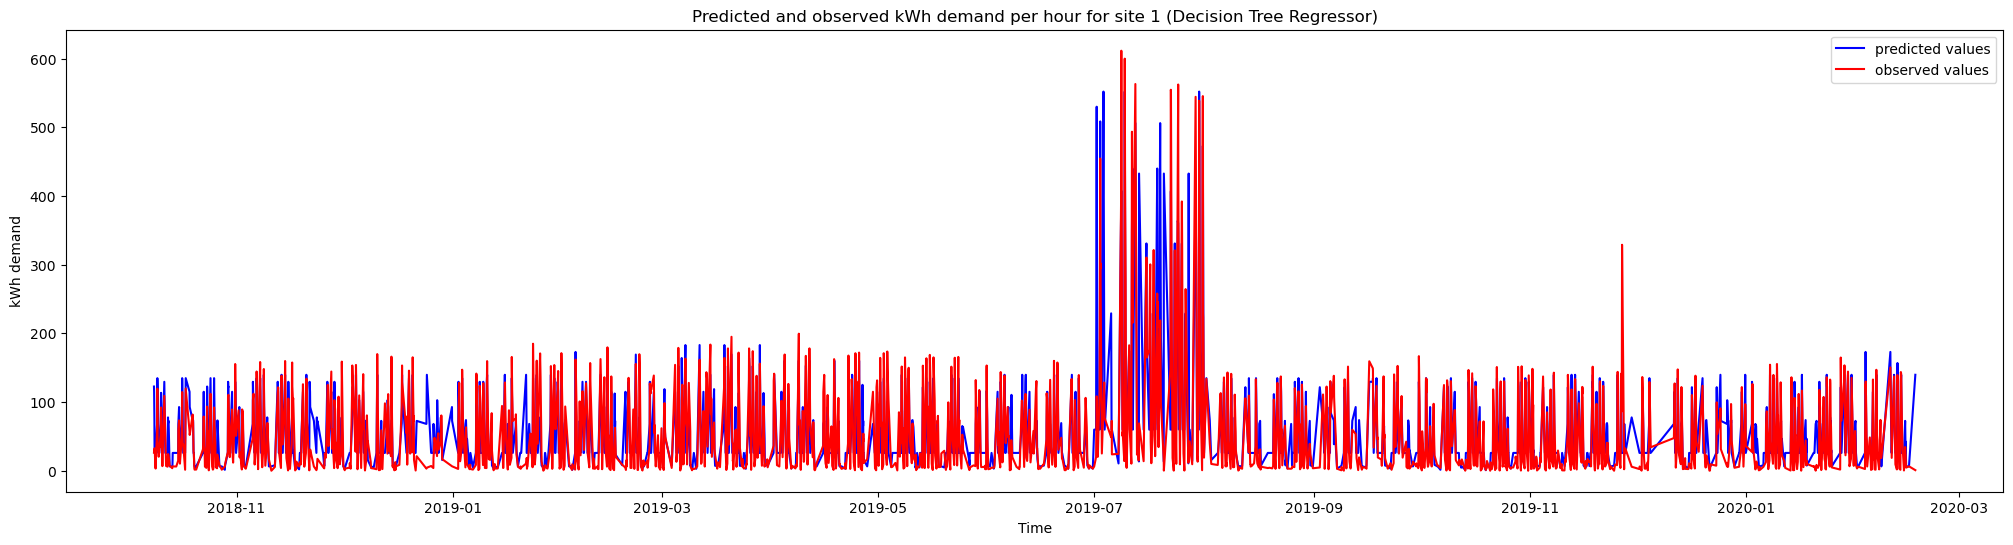

In [34]:
predictions_site1_tree = reg_tree.predict(scaler.transform(X_test_site1.drop("timestamp", axis = 1)))
timestamps = X_test_site1["timestamp"].sort_values()

# Visualization of difference between predicted and observed utilization rates for site 1
plt.figure(figsize = (25,6))

plt.plot(timestamps, predictions_site1_tree, c = "blue", label = "predicted values")
plt.plot(timestamps, Y_test_site1, c = "red", label = "observed values")

plt.xlabel("Time")
plt.ylabel("kWh demand")
plt.title("Predicted and observed kWh demand per hour for site 1 (Decision Tree Regressor)")
plt.legend()

plt.show()

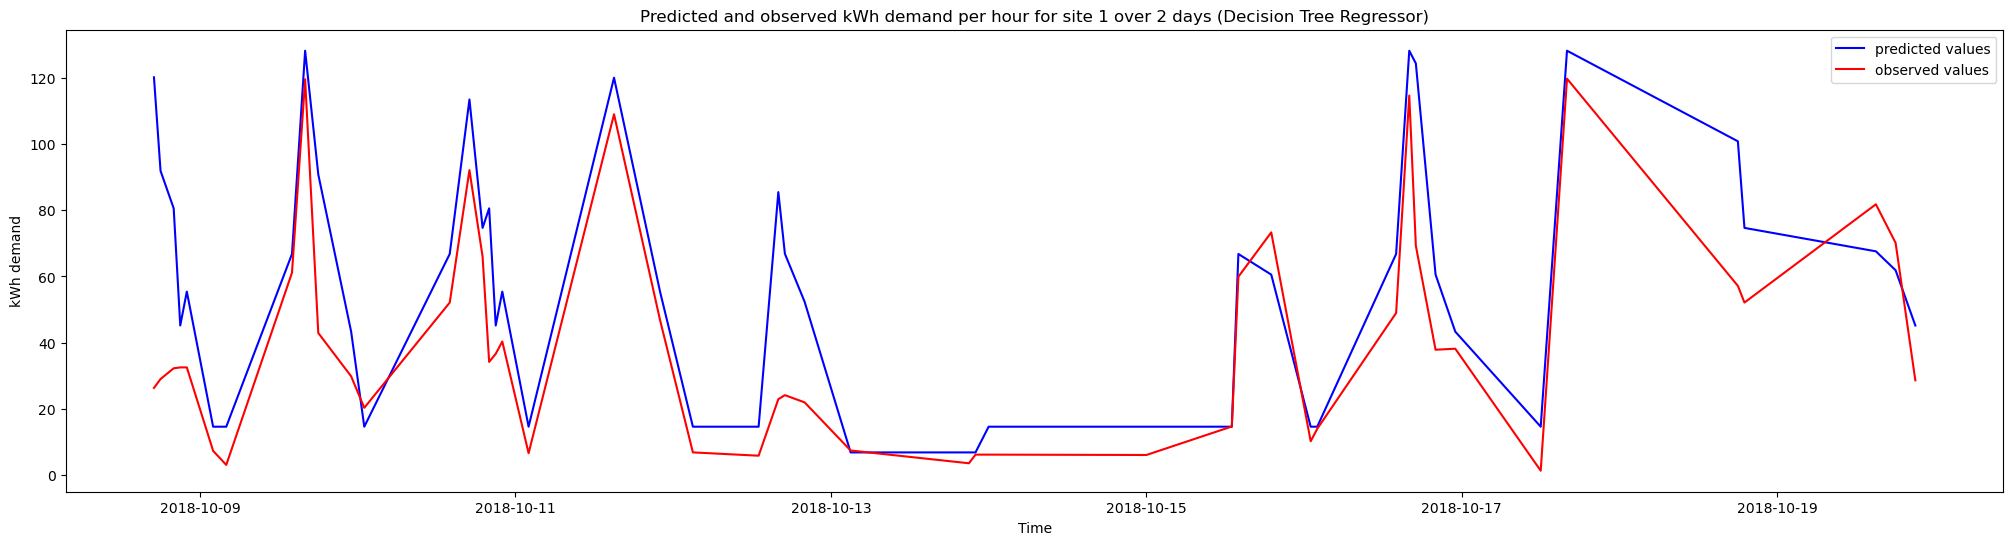

In [21]:
# Visualization of the predicted value and the observed value over 48 hours for site 1 (to visualize it better)
plt.figure(figsize = (25,6))

plt.plot(timestamps[0:48], predictions_site1_tree[0:48], c = "blue", label = "predicted values")
plt.plot(timestamps[0:48], Y_test_site1[0:48], c = "red", label = "observed values")

plt.xlabel("Time")
plt.ylabel("kWh demand")
plt.title("Predicted and observed kWh demand per hour for site 1 over 2 days (Decision Tree Regressor)")
plt.legend()

plt.show()

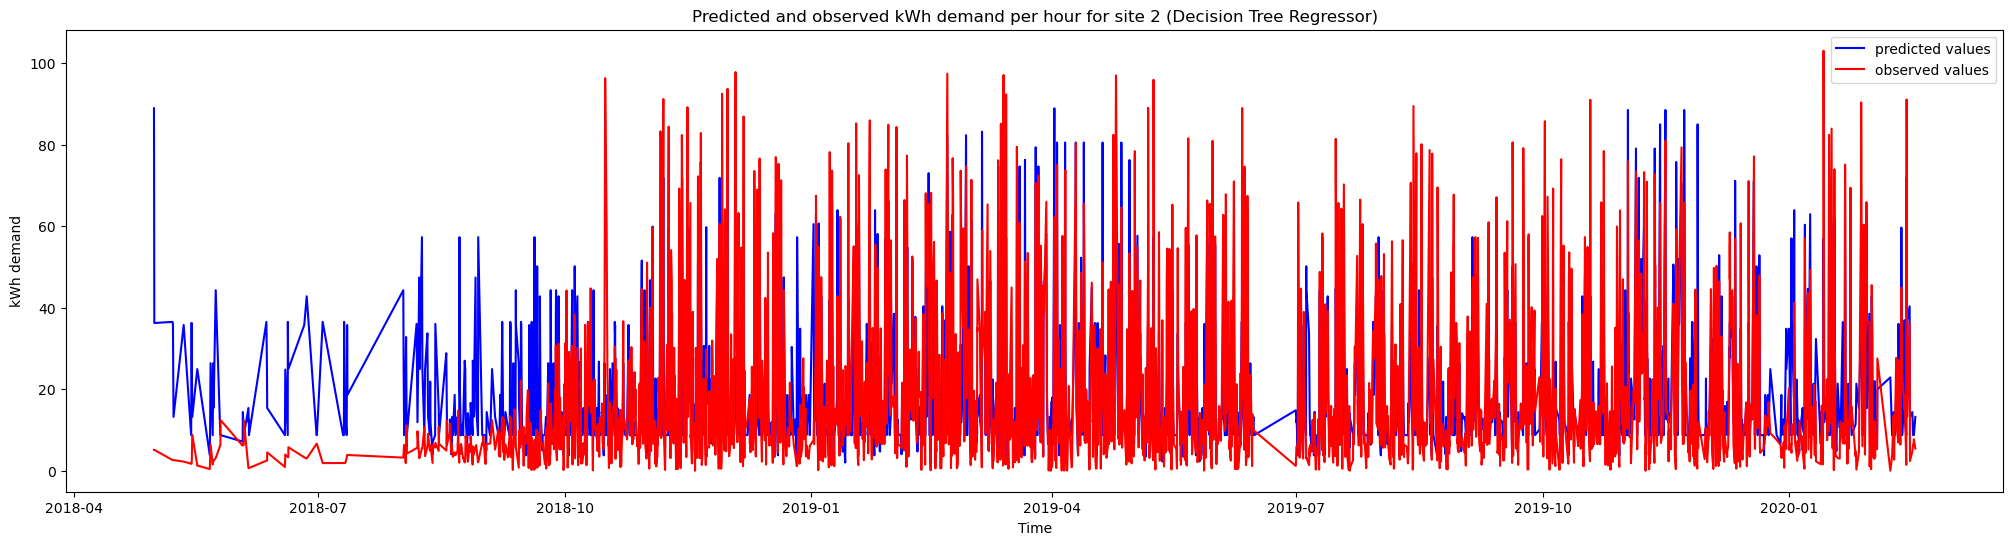

In [22]:
predictions_site2_tree = reg_tree.predict(scaler.transform(X_test_site2.drop("timestamp", axis = 1)))
timestamps = X_test_site2["timestamp"].sort_values()

# Visualization of difference between predicted and observed utilization rates for site 2
plt.figure(figsize = (25,6))

plt.plot(timestamps, predictions_site2_tree, c = "blue", label = "predicted values")
plt.plot(timestamps, Y_test_site2, c = "red", label = "observed values")

plt.xlabel("Time")
plt.ylabel("kWh demand")
plt.title("Predicted and observed kWh demand per hour for site 2 (Decision Tree Regressor)")
plt.legend()

plt.show()

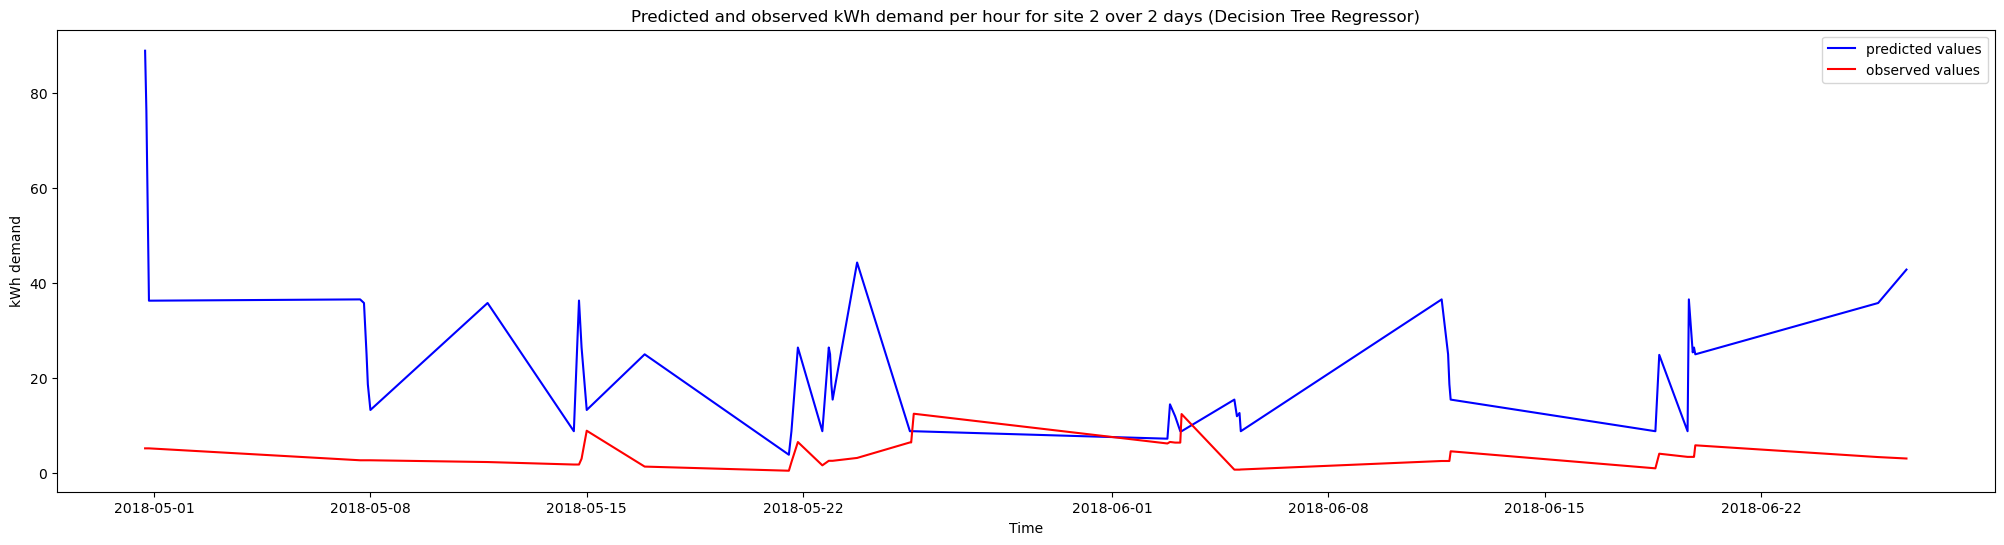

In [23]:
# Visualization of the predicted value and the observed value over 48 hours for site 2 (to visualize it better)
plt.figure(figsize = (25,6))

plt.plot(timestamps[0:48], predictions_site2_tree[0:48], c = "blue", label = "predicted values")
plt.plot(timestamps[0:48], Y_test_site2[0:48], c = "red", label = "observed values")

plt.xlabel("Time")
plt.ylabel("kWh demand")
plt.title("Predicted and observed kWh demand per hour for site 2 over 2 days (Decision Tree Regressor)")
plt.legend()

plt.show()

## Business Case Example

### Site 1 prediction for march 2024

In [24]:
# generate data for the first two weeks of march 2024 for site 1
date_range = pd.DataFrame({"timestamp": pd.date_range("2024-03-01", periods = 336, freq = "h")})

data = pd.DataFrame()
data["siteID_1"] = [True] * date_range.size
data["siteID_2"] = [False] * date_range.size

data["weekday"] = date_range["timestamp"].dt.day_name()
data = pd.get_dummies(data, columns = ["weekday"])

data["month_April"] = [False] * date_range.size
data["month_August"] = [False] * date_range.size
data["month_December"] = [False] * date_range.size
data["month_February"] = [False] * date_range.size
data["month_January"] = [False] * date_range.size
data["month_July"] = [False] * date_range.size
data["month_June"] = [False] * date_range.size
data["month_March"] = [True] * date_range.size
data["month_May"] = [False] * date_range.size
data["month_November"] = [False] * date_range.size
data["month_October"] = [False] * date_range.size
data["month_September"] =[False] * date_range.size
data["hour"] = date_range["timestamp"].dt.hour

data = pd.get_dummies(data, columns = ["hour"])

predictions_site1 = reg_tree.predict(scaler.transform(data))

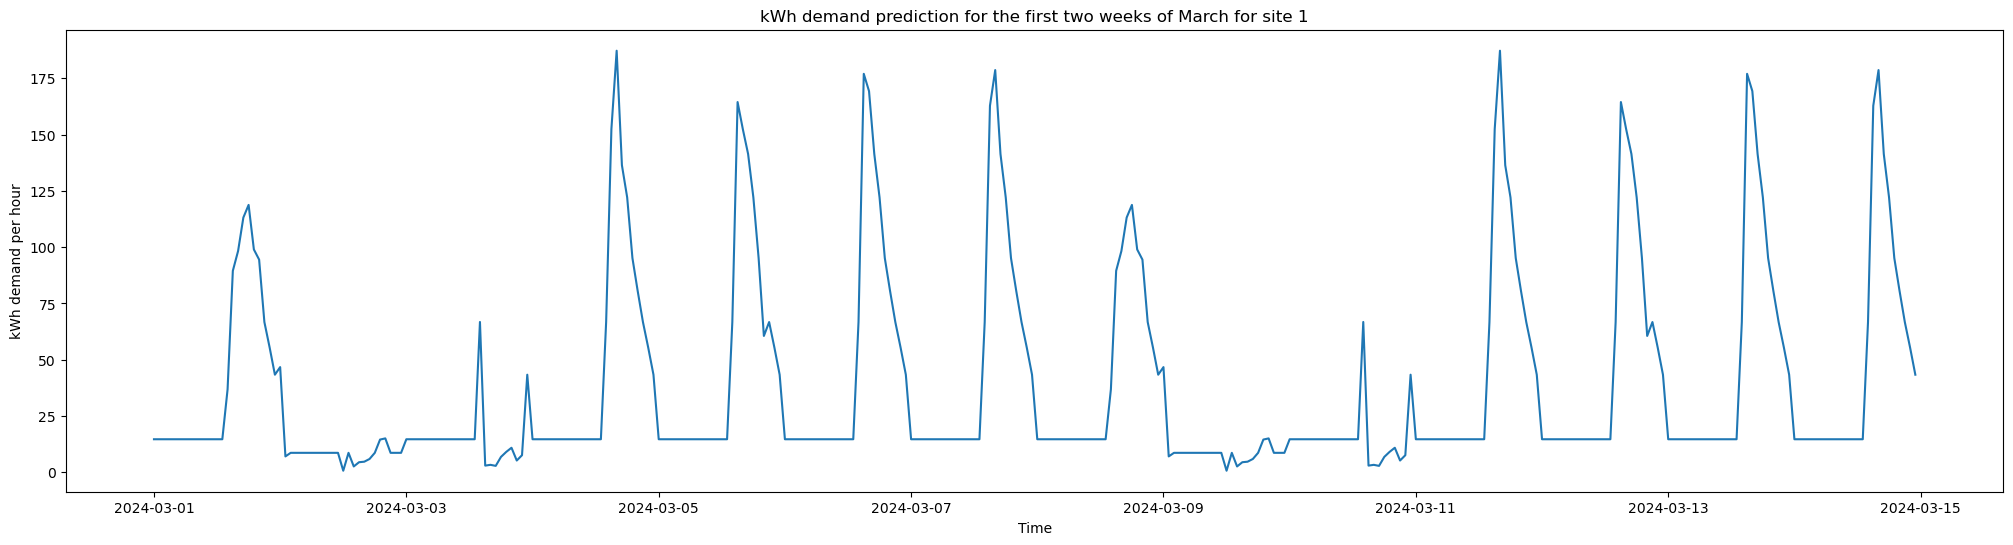

In [25]:
plt.figure(figsize = (25,6))
plt.plot(date_range, predictions_site1)

plt.xlabel("Time")
plt.ylabel("kWh demand per hour")
plt.title("kWh demand prediction for the first two weeks of March for site 1")

plt.show()

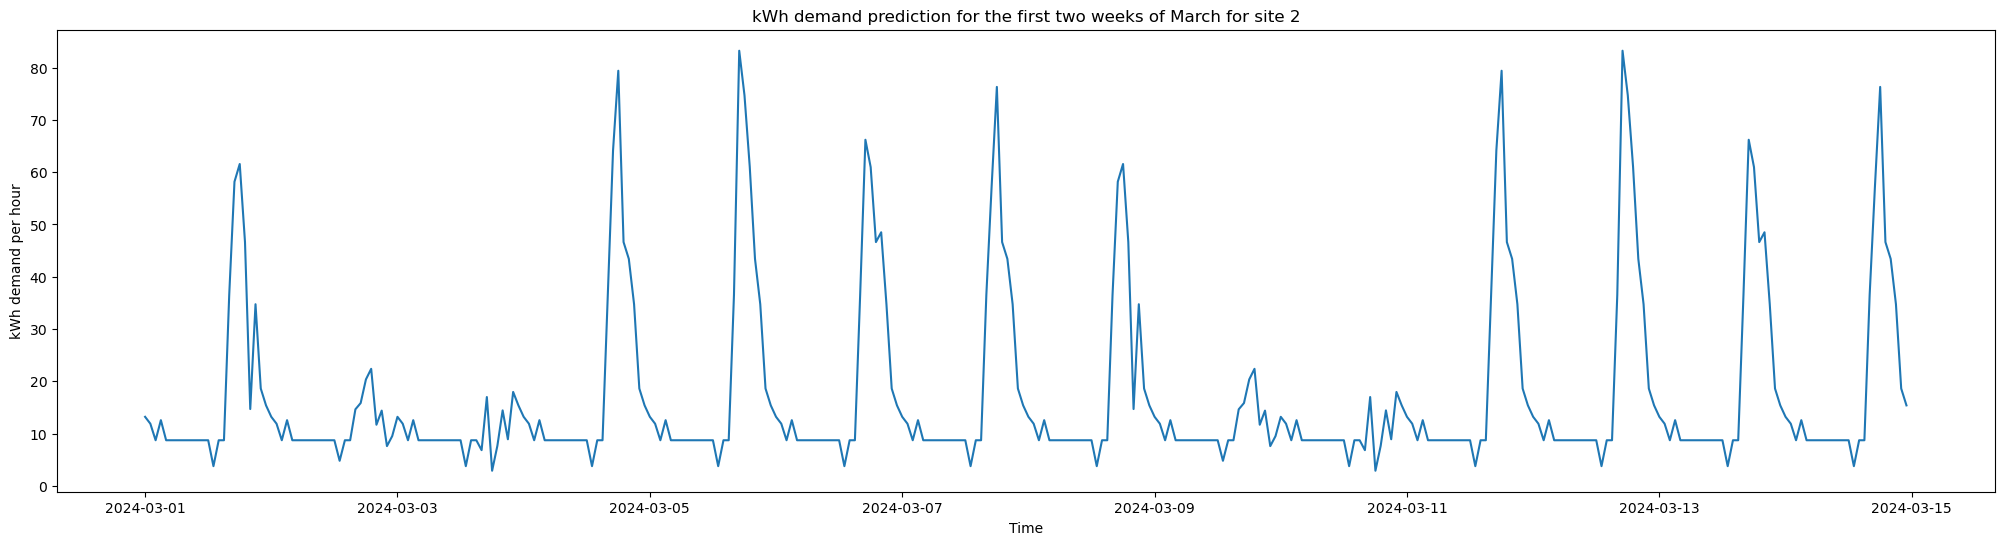

In [26]:
# generate data for the first two weeks of march 2024 for site 2
data["siteID_1"] = [False] * date_range.size
data["siteID_2"] = [True] * date_range.size

predictions_site2 = reg_tree.predict(scaler.transform(data))

plt.figure(figsize = (25,6))
plt.plot(date_range, predictions_site2)

plt.xlabel("Time")
plt.ylabel("kWh demand per hour")
plt.title("kWh demand prediction for the first two weeks of March for site 2")

plt.show()